<a href="https://colab.research.google.com/gist/Conal97/e5a422411564e6c2fb0e4dc68fd8ef5a/homogenous-lattice-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install mesa
!pip install holoviews
import numpy as np
import math
import random

import matplotlib.pyplot as plt
%matplotlib inline

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner

In [0]:
# Agents

class Individual(Agent):
    '''
    An individual on the grid.
    
    Attributes:
        x, y: Grid coordinates
        state: Can be "Suscpetible", "Zombie", or "Removed"
        unique_id: (x,y) tuple. 
    
    '''
    def __init__(self, model, pos):
        '''
        Create a new individual.
        Args:
            pos: The individual's coordinates on the grid. Used as the unique_id
        '''
        super().__init__(pos, model)
        self.pos = pos
        self.unique_id = pos
        self.condition = "Suscpetible"
        
    
    def update_neighbors(self):
        """
        Look around and see who neighbors are
        """
        self.neighborhood = self.model.grid.get_neighborhood(self.pos,
                                                        moore=False, radius=1)
        self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)


    def step(self):
        '''
        If the individual is a susceptible, check if it has zombie neighbours 
        if it does then it can either remove the zombie or be bitten and then become a zombie. 
        '''
        if self.condition == "Susceptible":
          
          self.update_neighbors()
          # determining which of the nearest neighbors are Zombies
          Zombie_neighbors = []
          for agent in self.neighbors:
            if agent.condition == "Zombie":
              Zombie_neighbors.append(agent)
          
          if Zombie_neighbors:
            # rate equations for determining if susceptible or zombie wins based on number of nearest neighbors

            k1 = 0.03 * (5 - len(Zombie_neighbors))
            k2 = 0.018 * len(Zombie_neighbors)
            K = k1 + k2

            # transitioning to zombie or removing zombie

            if random.uniform(0.0,1.0) < k1 / K:
              self.condition = "Zombie"
            else:
                for agent in Zombie_neighbors:
                  agent.condition = "Removed"

In [0]:
class ZombieApocalypse(Model):
    '''
    A model that simulates a Zombie Apocalypse.
    '''
    def __init__(self, height, width):
        '''
        Create a Zombie Apocalypse model.
        
        Args:
            height, width: The size of the grid to model
            Each cell will have an individual, so the number of agents equals heigh * width. 
        '''
        # Initialize model parameters
        self.height = height
        self.width = width
        
        # Set up model objects
        self.schedule = RandomActivation(self)
        self.grid = SingleGrid(height, width, torus=False)
        self.dc = DataCollector(
            model_reporters = {"Susceptible": lambda m: self.count_type(m, "Susceptible"),
                                "Zombie": lambda m: self.count_type(m, "Zombie"),
                                "Removed": lambda m: self.count_type(m, "Removed")})
        
        # Place an individual in each celll
        for x in range(self.width):
            for y in range(self.height):
                    # Create a new individual
                    new_Individual = Individual(self, (x, y))
                    new_Individual.condition = "Susceptible"
                    # Seeding patient zero
                    if (x,y) == (22,54) :
                      new_Individual.condition = "Zombie"
                    self.grid[y][x] = new_Individual
                    self.schedule.add(new_Individual)
        self.running = True
        
    def step(self):
        '''
        Advance the model by one step.
        '''
        self.schedule.step()
        self.dc.collect(self)
        # Halt simulation if there are no more Susceptibles or Zombies
        if self.count_type(self, "Susceptibles") or self.count_type(self, "Zombies") == 0:
            self.running = False
    
    @staticmethod
    def count_type(model, Individual_condition):
        '''
        Helper method to count trees in a given condition in a given model.
        '''
        count = 0
        for Individual in model.schedule.agents:
            if Individual.condition == Individual_condition:
                count += 1
        return count

In [0]:
Apocalypse = ZombieApocalypse(100, 100)
for i in range(100):
    Apocalypse.step()

**Plotting Trajectories**

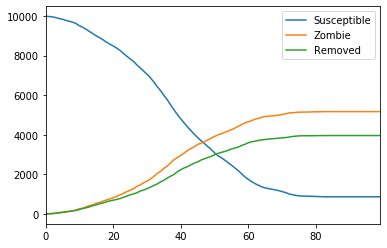

In [0]:
results = Apocalypse.dc.get_model_vars_dataframe()
results.plot()

In [0]:
Apocalypse = ZombieApocalypse(100, 100)

def value(cell):
    if cell.condition == 'Susceptible': return 1
    elif cell.condition == 'Zombie': return 2
    elif cell.condition == 'Removed': return 3

for i in range(100):
    Apocalypse.step()
    data = np.array([[value(c) for c in row] for row in Apocalypse.grid.grid])
  

**Visualising End State**

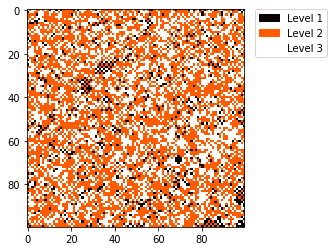

In [0]:
import matplotlib.patches as mpatches
values = np.unique(data.ravel())
im = plt.imshow(data, cmap = 'hot', interpolation='none')
colors = [ im.cmap(im.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label="Level {l}".format(l=values[i]) ) for i in range(len(values)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.show()